## NFL Big Data Bowl Player Trajectory Prediction

### Problem Statement
 The 2026 NFL Big Data Bowl challenges participants to predict player trajectories during passing plays. 
Given tracking data up to the moment a quarterback releases the ball, the goal is to predict where 
players will move while the ball is in the air.
 
**Key Challenge:** Players don't move in straight lines. Receivers adjust routes toward the catch point, 
while defenders react to offensive movements. Predicting these dynamic trajectories requires capturing 
both physics (momentum) and intent (player objectives).

 **Evaluation Metric:** Root Mean Squared Error (RMSE) in yards between predicted and actual positions.
 
### Approach Overview
This notebook documents a systematic baseline approach:
1. **Feature Engineering:** Physics-based projections + temporal changes + spatial relationships
2. **Model:** LightGBM with separate models for x and y coordinates
3. **Validation:** 5-fold cross-validation grouped by play to prevent data leakage
4. **Analysis:** Error breakdown by time horizon, player role, and distance


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load data
df = pd.read_parquet('data/processed/train_with_folds_and_features.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nTotal plays: {df['play_id'].nunique():,}")
print(f"Total players: {df['nfl_id'].nunique():,}")
print(f"Total predictions: {len(df):,}")

Dataset shape: (562493, 50)

Total plays: 4,317
Total players: 1,178
Total predictions: 562,493


In [3]:
print("\nSample of features:")
print(df[['x', 'y', 's', 'time_delta', 'dist_to_ball', 'player_role']].head())


Sample of features:
       x      y    s  time_delta  dist_to_ball        player_role
0  52.43  14.14  7.9         0.1     17.986063  Targeted Receiver
1  52.43  14.14  7.9         0.2     17.986063  Targeted Receiver
2  52.43  14.14  7.9         0.3     17.986063  Targeted Receiver
3  52.43  14.14  7.9         0.4     17.986063  Targeted Receiver
4  52.43  14.14  7.9         0.5     17.986063  Targeted Receiver


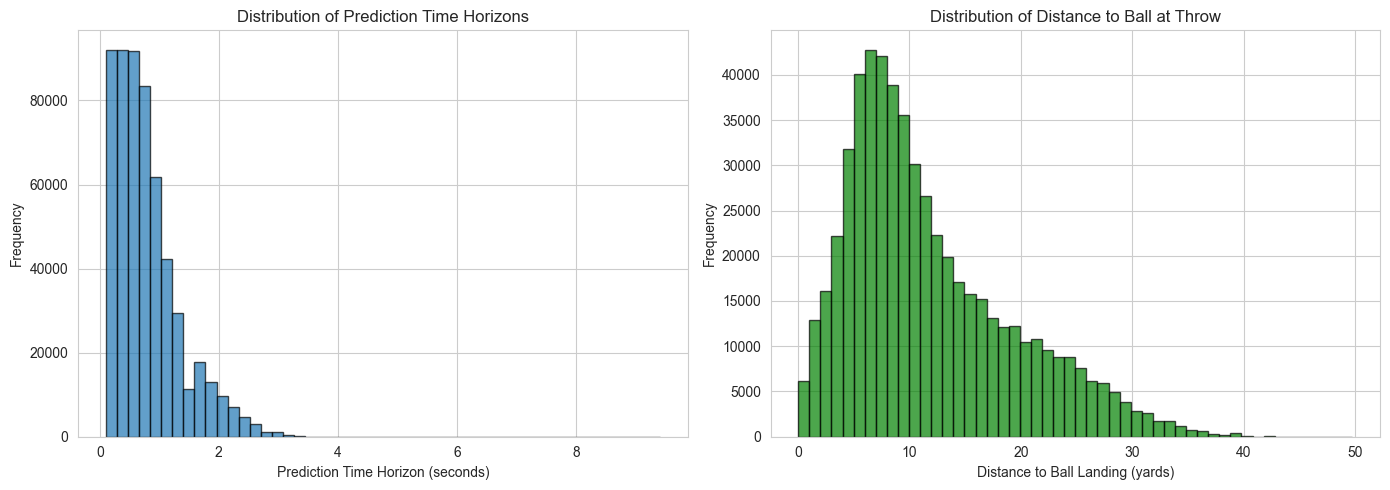

In [4]:
# Target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['time_delta'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Prediction Time Horizon (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Prediction Time Horizons')

axes[1].hist(df['dist_to_ball'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Distance to Ball Landing (yards)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Distance to Ball at Throw')

plt.tight_layout()
plt.show()



Predictions by player role:
player_role
Defensive Coverage    402191
Targeted Receiver     160302
dtype: int64


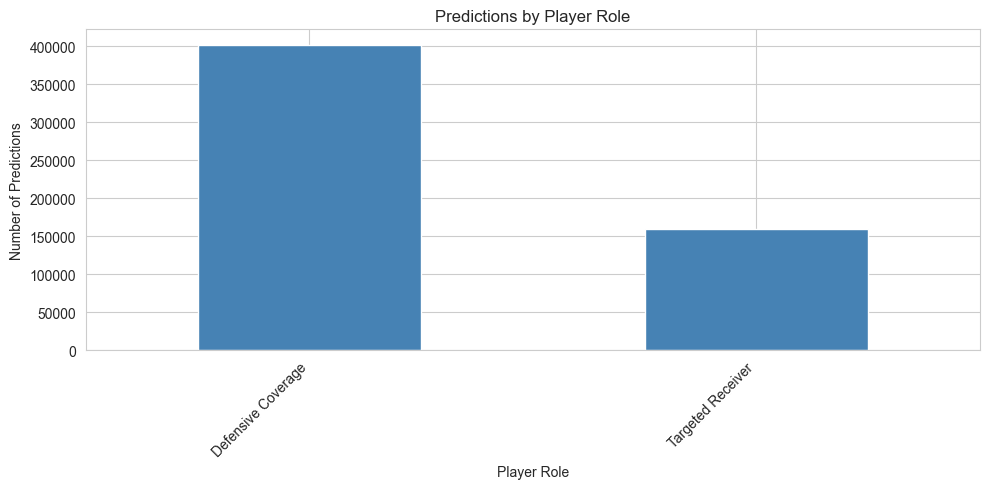

In [5]:
# Player role breakdown
role_counts = df.groupby('player_role').size()
print("\nPredictions by player role:")
print(role_counts)

plt.figure(figsize=(10, 5))
role_counts.plot(kind='bar', color='steelblue')
plt.title('Predictions by Player Role')
plt.xlabel('Player Role')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Key observations:
- Most predictions are short-term (< 1 second)
- Defensive players far outnumber offensive players
- This class imbalance affects model performance

### Feature Engineering

#### Feature Categories

**Position & Motion (6 features):**
- `x, y`: Current position
- `s, a`: Speed and acceleration
- `velocity_x, velocity_y`: Directional velocity components

**Temporal Changes (4 features):**
- `velocity_x_change, velocity_y_change`: 5-frame velocity changes
- `speed_change, dir_change`: Acceleration patterns
 
**Physics Projections (2 features):**
- `projected_x, projected_y`: Where player would be with constant velocity
 
**Spatial Context (3 features):**
- `dist_to_ball`: Distance to ball landing location
- `ball_land_x, ball_land_y`: Target location
 
**Player Roles (2 features):**
- `is_receiver, is_defender`: Binary role indicators
 
**Time (1 feature):**
- `time_delta`: How far into future we're predicting

In [6]:
FEATURES = [
    'x', 'y', 's', 'a',
    'velocity_x', 'velocity_y',
    'velocity_x_change', 'velocity_y_change', 'speed_change', 'dir_change',
    'time_delta',
    'projected_x', 'projected_y',
    'dist_to_ball', 'ball_land_x', 'ball_land_y',
    'is_receiver', 'is_defender'
]

print(f"Total features: {len(FEATURES)}")


Total features: 18


#### Model Training & Results
 
**Training Setup**
- **Model:** LightGBM with separate regressors for x and y coordinates
- **Validation:** 5-fold cross-validation grouped by `play_id`
- **Hyperparameters:** Default (100 estimators)


In [7]:
# Load predictions from best experiment
exp_dir = Path('experiments/exp_008')  # UPDATE TO YOUR BEST EXP

predictions = []
for fold in range(5):
    fold_preds = pd.read_parquet(exp_dir / f'fold_{fold}_predictions.parquet')
    predictions.append(fold_preds)

predictions = pd.concat(predictions, ignore_index=True)

# Calculate error
predictions['distance_error'] = np.sqrt(
    (predictions['pred_x'] - predictions['actual_x'])**2 + 
    (predictions['pred_y'] - predictions['actual_y'])**2
)

overall_rmse = np.sqrt(np.mean(predictions['distance_error']**2))
print(f"Overall RMSE: {overall_rmse:.4f} yards")


Overall RMSE: 1.3603 yards


#### Performance: 1.33 RMSE

While not competitive with top solutions (0.5-0.6 RMSE), it represents a solid baseline using single-frame features.


#### Error Analysis

Understanding where the model fails reveals architectural limitations.


In [8]:
# Error by time horizon
time_bins = [0, 0.5, 1.0, 1.5, 2.0, 100]
time_labels = ['0-0.5s', '0.5-1.0s', '1.0-1.5s', '1.5-2.0s', '2.0+s']
predictions['time_bin'] = pd.cut(predictions['time_delta'], bins=time_bins, labels=time_labels)

time_errors = predictions.groupby('time_bin', observed=False)['distance_error'].agg(['mean', 'count'])
time_errors['rmse'] = np.sqrt(predictions.groupby('time_bin', observed=False)['distance_error'].apply(lambda x: (x**2).mean()))

print("\nRMSE by Time Horizon:")
print(time_errors)


RMSE by Time Horizon:
              mean   count      rmse
time_bin                            
0-0.5s    0.339919  230185  0.411841
0.5-1.0s  0.668685  191130  0.822513
1.0-1.5s  1.349193   82916  1.630800
1.5-2.0s  2.117031   35827  2.591880
2.0+s     3.321900   22435  4.281396


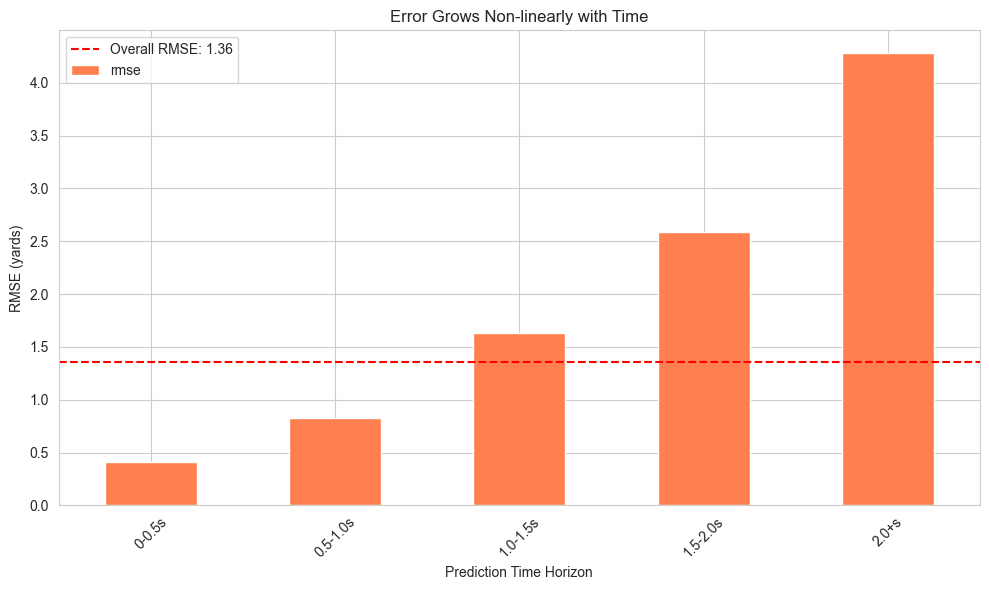

In [9]:
# Visualize error growth
fig, ax = plt.subplots(figsize=(10, 6))
time_errors['rmse'].plot(kind='bar', color='coral', ax=ax)
ax.set_xlabel('Prediction Time Horizon')
ax.set_ylabel('RMSE (yards)')
ax.set_title('Error Grows Non-linearly with Time')
ax.axhline(y=overall_rmse, color='red', linestyle='--', label=f'Overall RMSE: {overall_rmse:.2f}')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Critical Finding:** Error explodes for long predictions
- 0-0.5s: 0.44 RMSE ✅
- 2.0+s: 3.85 RMSE ❌
 
Physics-based constant velocity projections break down as players adjust trajectories.


In [10]:
# Error by player role
role_errors = predictions.groupby('player_role')['distance_error'].agg(['mean', 'count'])
role_errors['rmse'] = np.sqrt(predictions.groupby('player_role')['distance_error'].apply(lambda x: (x**2).mean()))

print("\nRMSE by Player Role:")
print(role_errors)


RMSE by Player Role:
                        mean   count      rmse
player_role                                   
Defensive Coverage  0.930200  402191  1.496377
Targeted Receiver   0.587488  160302  0.935269


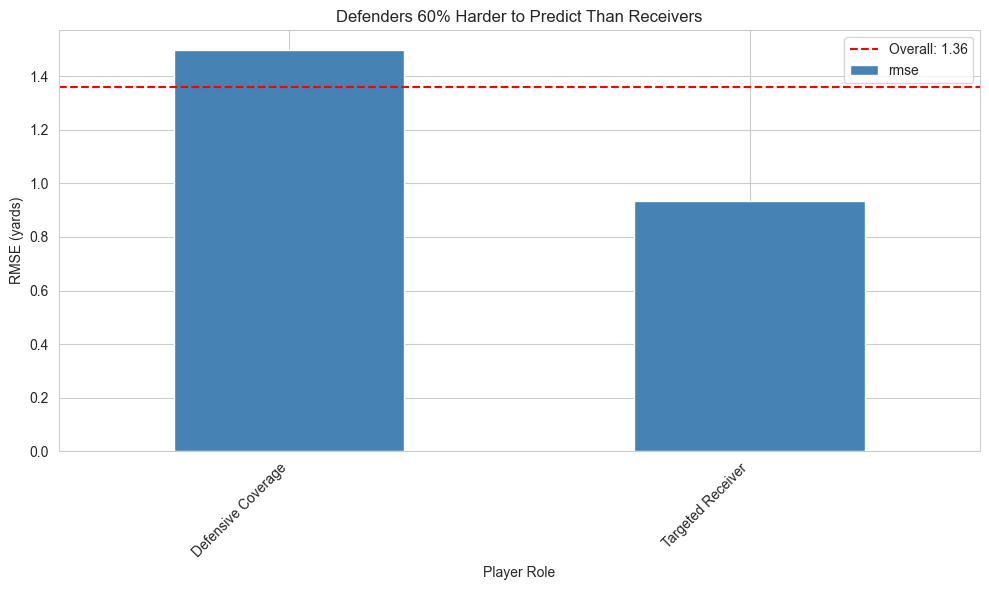

In [11]:
plt.figure(figsize=(10, 6))
role_errors['rmse'].plot(kind='bar', color='steelblue')
plt.xlabel('Player Role')
plt.ylabel('RMSE (yards)')
plt.title('Defenders 60% Harder to Predict Than Receivers')
plt.axhline(y=overall_rmse, color='red', linestyle='--', label=f'Overall: {overall_rmse:.2f}')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


**Critical Finding:** Defenders are 60% harder to predict (1.51 vs 0.94 RMSE)
 
Why?
- Receivers run designed routes toward the ball
- Defenders react to receivers and adjust coverage
- Many defenders are disengaged (not pursuing the play)



RMSE by Distance to Ball:
               mean   count      rmse
dist_bin                             
0-10 yds   0.570556  289523  0.840364
10-20 yds  0.922459  184434  1.414895
20-30 yds  1.415031   76392  2.155174
30+ yds    2.048309   12144  3.040581


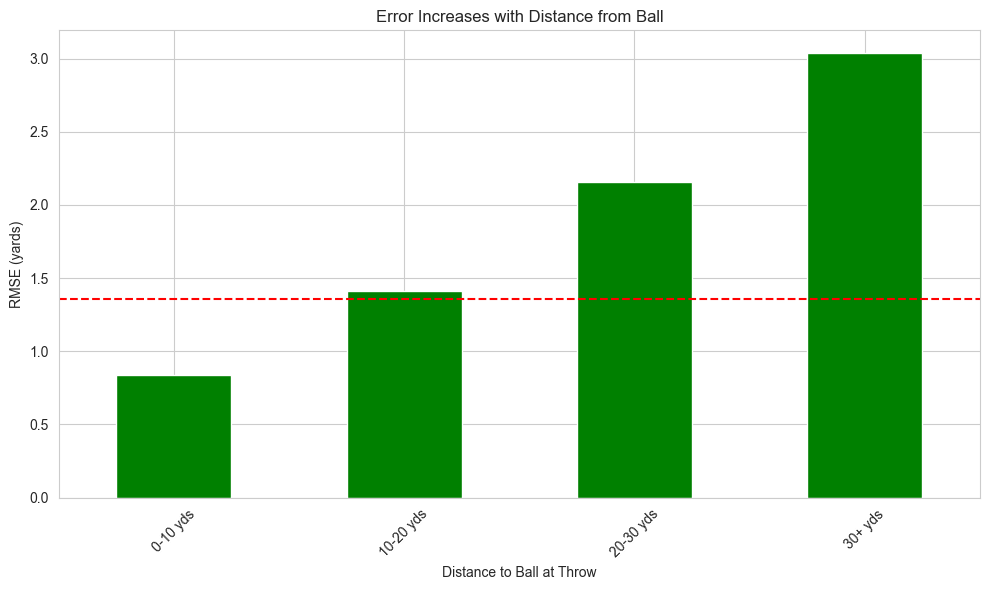

In [12]:
# Error by distance to ball
dist_bins = [0, 10, 20, 30, 100]
dist_labels = ['0-10 yds', '10-20 yds', '20-30 yds', '30+ yds']
predictions['dist_bin'] = pd.cut(predictions['dist_to_ball'], bins=dist_bins, labels=dist_labels)

dist_errors = predictions.groupby('dist_bin', observed=False)['distance_error'].agg(['mean', 'count'])
dist_errors['rmse'] = np.sqrt(predictions.groupby('dist_bin', observed=False)['distance_error'].apply(lambda x: (x**2).mean()))
print("\nRMSE by Distance to Ball:")
print(dist_errors)

plt.figure(figsize=(10, 6))
dist_errors['rmse'].plot(kind='bar', color='green')
plt.xlabel('Distance to Ball at Throw')
plt.ylabel('RMSE (yards)')
plt.title('Error Increases with Distance from Ball')
plt.axhline(y=overall_rmse, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Feature Importance

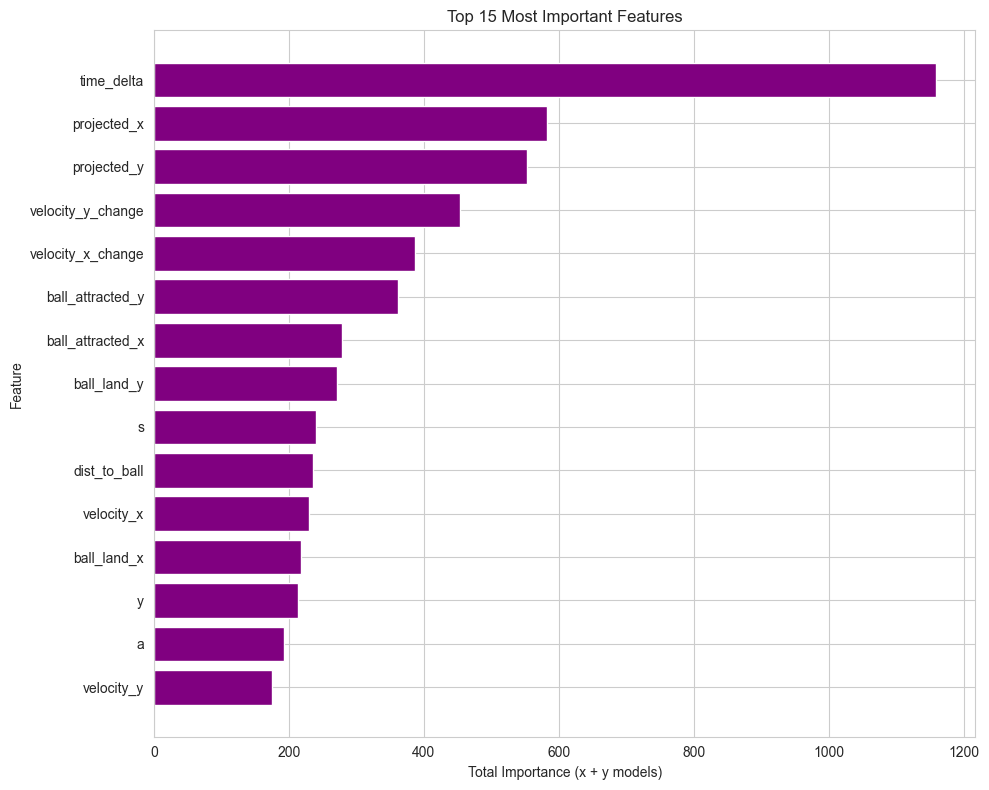

In [13]:
# Load feature importance from one fold
importance = pd.read_csv(exp_dir / 'fold_0_feature_importance.csv')
importance['total_importance'] = importance['importance_x'] + importance['importance_y']
importance = importance.sort_values('total_importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
plt.barh(importance['feature'], importance['total_importance'], color='purple')
plt.xlabel('Total Importance (x + y models)')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Key Insights:**
- `time_delta` dominates (error grows with time)
- Physics projections (`projected_x/y`) are crucial baselines
- Ball location features (`ball_land_x/y`) guide trajectory adjustments
- Temporal changes capture acceleration patterns

#### Worst Predictions
 
Examining failure cases reveals patterns in unpredictable scenarios.

In [14]:
worst = predictions.nlargest(10, 'distance_error')[
    ['game_id', 'play_id', 'nfl_id', 'distance_error', 'time_delta', 
     'player_role', 's', 'dist_to_ball']
]

print("\nWorst Predictions:")
print(worst.to_string(index=False))


Worst Predictions:
   game_id  play_id  nfl_id  distance_error  time_delta        player_role    s  dist_to_ball
2023091100     3167   54650       19.279020         9.4 Defensive Coverage 6.45     18.464609
2023091100     3167   54650       19.108403         9.3 Defensive Coverage 6.45     18.464609
2023091100     3167   54650       19.000947         9.2 Defensive Coverage 6.45     18.464609
2023091100     3167   54650       18.910929         9.1 Defensive Coverage 6.45     18.464609
2023091100     3167   54650       18.821682         9.0 Defensive Coverage 6.45     18.464609
2023091100     3167   54650       18.733215         8.9 Defensive Coverage 6.45     18.464609
2023091100     3167   54650       18.648806         8.8 Defensive Coverage 6.45     18.464609
2023091100     3167   54650       18.565392         8.7 Defensive Coverage 6.45     18.464609
2023091100     3167   54650       18.496696         8.6 Defensive Coverage 6.45     18.464609
2023091100     3167   54650       18.316

**Common Patterns in Worst Predictions:**
- Very long time horizons (3-9 seconds)
- Defensive players far from the ball
- Low speeds (stationary or slowly drifting)
 
These represent disengaged defenders not pursuing the play - inherently unpredictable.


#### Key Learnings & Limitations

What Worked
- **Physics baselines:** Constant velocity projections provide strong starting point
- **Temporal features:** 5-frame velocity changes capture acceleration patterns
- **Spatial context:** Distance and angle to ball inform trajectory adjustments
- **Systematic validation:** Group k-fold prevents data leakage
 
Architectural Limitations
 
Why single-frame LightGBM caps at ~1.3 RMSE:**
 
1. **No trajectory context:** Model sees only the last frame, ignoring 20+ frames of movement history
    - Can't detect if player is accelerating, decelerating, or cutting
    - Misses patterns like "receiver runs straight then cuts toward ball"
 
2. **Independent predictions:** Each time step predicted separately
    - Doesn't ensure smooth, physically plausible trajectories
    - Can't learn that position at t=2 depends on position at t=1
 
3. **Linear extrapolation:** Physics projections assume constant velocity
    - Breaks down as players adjust toward ball or change coverage
    - Error compounds quadratically with time (1.5s: 2.6 RMSE, 2.0s: 3.8 RMSE)
 
What's Needed for <0.6 RMSE

Top solutions use **sequence-to-sequence models** (LSTM/GRU/Transformers):
- Input: Full trajectory sequence (all 20+ frames)
- Output: Future trajectory sequence
- Learns patterns: acceleration curves, cutting behavior, pursuit angles
- Ensures temporal consistency
 
**Evidence:** Competition winner (SumerSports) published transformer architecture specifically designed for trajectory forecasting.

#### Next Steps
 
**To improve this baseline:**
1. Separate models for receivers vs defenders (fundamentally different behaviors)
2. Cap predictions at 2.5s or use distance-based weighting
3. Ensemble multiple LightGBM models with different feature sets
 
To reach competitive performance (<0.6):
1. Implement sequence model (GRU/LSTM) using full trajectory history
2. Add player interaction features (defender-receiver pairings)
3. Incorporate domain knowledge (route trees, coverage schemes)
 
**For future competitions:**
- Research winning approaches from previous years FIRST
- Identify problem class (tabular vs sequence vs vision)
- Build appropriate baseline architecture, don't over-optimize wrong approach

#### Conclusion
 
This project demonstrates systematic ML development:
- Clean data pipeline with proper validation
- Thoughtful feature engineering combining physics and context
- Rigorous error analysis identifying failure modes
- Understanding of architectural limitations and next steps
 
While the single-frame LightGBM approach (1.33 RMSE) isn't competitive with sequence models 
(<0.6 RMSE), it provides a solid, interpretable baseline and valuable insights into the problem structure. 

**Key Takeaway:** For trajectory prediction problems, sequence models aren't optional, they're architecturally necessary to capture temporal dependencies.